In [1]:
# import modules
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

plt.style.use('ggplot')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# generate synthetic data for linear regression
# set random seed
np.random.seed(9)
# draw 100 random numbers from uniform dist [0, 1]
x = np.random.uniform(0, 1, (100, 1))
# draw random noise from standard normal
z = np.random.normal(0, .1, (100, 1))
# create ground truth for y = 8x - 3
y = 3 * x - 1 + z

In [3]:
# move data from numpy to torch
x_tensor = torch.from_numpy(x).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)
# create tensor dataset from tensor
dataset = TensorDataset(x_tensor, y_tensor)
print(dataset[0])

(tensor([0.0104]), tensor([-1.0155]))


In [4]:
# split data into train and eval
train_dataset, val_dataset = random_split(dataset, [80, 20])
# create data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=8)
val_loader = DataLoader(dataset=val_dataset, batch_size=10)

In [5]:
# define our linear regression model in pytorch
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        return self.linear(x)

In [6]:
# initialize our model
model = LinearRegression().to(device)
# state_dict() contains the parameters of the model
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-0.9747]])), ('linear.bias', tensor([0.8959]))])


In [7]:
# set training routine
lr = 1e-1
n_epochs = 50

# create loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

In [8]:
def train_one_batch(model, loss_fn, optimizer, x_batch, y_batch):
    model.train()
    # forward pass
    yhat = model(x_batch)
    # calculate training loss
    loss = loss_fn(y_batch, yhat)
    # gradient descend
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

In [9]:
# train model
losses = []
val_losses = []
for epoch in range(n_epochs):
    print("[ epoch ]", epoch)
    tmp_losses = []
    for idx, (x_batch, y_batch) in enumerate(train_loader, 1):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_one_batch(model, loss_fn, optimizer, x_batch, y_batch)
        tmp_losses.append(loss)
    print("[ training ] training loss = {}".format(sum(tmp_losses)/idx))
    losses.append(sum(tmp_losses)/idx)
    # eval
    with torch.no_grad():
        # set eval mode
        model.eval()
        tmp_val_losses = []
        for idx, (x_batch, y_batch) in enumerate(val_loader, 1):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            yhat = model(x_batch)
            tmp_val_losses.append(loss_fn(y_batch, yhat).item())
        print("[ eval ] validation loss = {}".format(sum(tmp_val_losses)/idx))
        val_losses.append(sum(tmp_val_losses)/idx)
        
print(model.state_dict())

[ epoch ] 0
[ training ] training loss = 1.1215528815984726
[ eval ] validation loss = 1.0084198415279388
[ epoch ] 1
[ training ] training loss = 0.8764605939388275
[ eval ] validation loss = 0.7767042815685272
[ epoch ] 2
[ training ] training loss = 0.686298654973507
[ eval ] validation loss = 0.5973736941814423
[ epoch ] 3
[ training ] training loss = 0.5379058629274368
[ eval ] validation loss = 0.4587131291627884
[ epoch ] 4
[ training ] training loss = 0.42206495851278303
[ eval ] validation loss = 0.3516424596309662
[ epoch ] 5
[ training ] training loss = 0.33163179606199267
[ eval ] validation loss = 0.2690941244363785
[ epoch ] 6
[ training ] training loss = 0.26103226840496063
[ eval ] validation loss = 0.2055673971772194
[ epoch ] 7
[ training ] training loss = 0.20591538324952124
[ eval ] validation loss = 0.15678245574235916
[ epoch ] 8
[ training ] training loss = 0.16288483403623105
[ eval ] validation loss = 0.11941111087799072
[ epoch ] 9
[ training ] training loss =

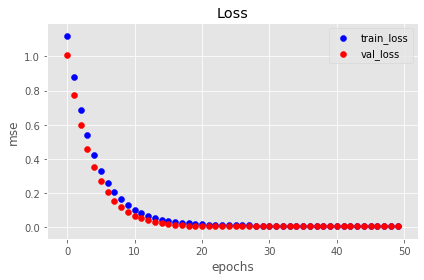

In [10]:
plt.scatter(range(n_epochs), losses, label='train_loss', color='b')
plt.scatter(range(n_epochs), val_losses, label='val_loss', color='r')
plt.legend()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.tight_layout()